In [58]:
!pip install timm
!pip install torchsummary
!pip install pytorch_msssim

In [59]:
import timm
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import numpy as np
import cv2
from tqdm.auto import tqdm
import os

In [60]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [61]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
class Encoder(nn.Module):
    def __init__(self, backbone = 'resnet34'):
        super(Encoder, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained = True)
        self.List = list(self.backbone.children())[:-4]

    def forward(self,X):
        for i,layer in enumerate(self.List):
            X = layer(X)
        return X


class discretize(nn.Module):
    def __init__(self, n_e, e_dim, beta=0.25):
        super(discretize, self).__init__()
        self.e_dim = e_dim
        self.n_e = n_e
    
        self.beta = beta
        self.code_book = nn.Embedding(n_e, e_dim)
        self.softmax = nn.Softmax(dim=1)
        self.code_book.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

    def forward(self, enc):
        enc = enc.permute(0,2,3,1).contiguous()
        enc_flattened = enc.view(-1, self.e_dim)

        distances = (torch.sum(enc_flattened**2, dim=1, keepdim = True) +
                     torch.sum(self.code_book.weight**2, dim=1)
                        -2*torch.matmul(enc_flattened, self.code_book.weight.t()))

        min_encoding_ids = torch.argmin(distances, dim=1).unsqueeze(1)
        min_encodings_mask = torch.zeros(min_encoding_ids.shape[0], self.n_e, dtype = self.code_book.weight.dtype).to(enc.device)
        min_encodings_mask.scatter_(1, min_encoding_ids, 1)
        latent_reps = torch.matmul(min_encodings_mask, self.code_book.weight).view(enc.shape)
        codebook_loss = F.mse_loss(latent_reps.detach(),enc) + self.beta * F.mse_loss(latent_reps , enc.detach())
        latent_reps = enc + (latent_reps-enc).detach()

        e_mean = torch.mean(min_encodings_mask, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        latent_reps = latent_reps.permute(0, 3, 1, 2).contiguous()

        return latent_reps, codebook_loss, perplexity

class Decoder(nn.Module):
    
    def __init__(self, stride = 2):
        super(Decoder, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode = 'bilinear')
        self.upsample1 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1)
        self.upsample3 = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)
        self.conv1 = ResidualStack(128, 64, 256,2)
        self.conv2 = ResidualStack(64, 32, 128,3)
        self.conv3 = ResidualStack(32, 16, 64,3)
        self.conv4 = ResidualStack(16, 8, 32,3)
        self.conv5 = nn.Conv2d(8, 3, kernel_size=1,
                      stride=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,X):
        X = self.conv1(X) 
        X = self.upsample1(X, output_size=(X.size(0),X.size(1),X.size(2)*2,X.size(3)*2))        #56
        X = self.conv2(X) 
        X = self.upsample2(X, output_size=(X.size(0),X.size(1),X.size(2)*2,X.size(3)*2))       #112
        X = self.conv3(X)
        X = self.upsample3(X, output_size=(X.size(0),X.size(1),X.size(2)*2,X.size(3)*2))       #224
        X = self.conv4(X)
        X = self.conv5(X)
        return self.sigmoid(X)


class ResidualLayer(nn.Module):

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, in_dim, kernel_size=1,
                      stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        x = F.relu(x)
        return x


class ResidualStack(nn.Module):

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)
        self.conv = nn.Conv2d(in_dim, h_dim, kernel_size=1)
    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(self.conv(x))
        return x


In [88]:
dummy_en = Encoder().to(DEVICE)
dummy_de = Decoder().to(DEVICE)
#print(dummy_en(torch.zeros(1,3,128,128).to("cuda")).shape)
summary(dummy_en, (3, 224, 224))
summary(dummy_de, (128,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [79]:
class BirdDataset(Dataset):

    def __init__(self, img_pths, device = "cpu"):
        self.device = device
        self.img_pths = img_pths

    def __len__(self):
        return len(self.img_pths)
    
    def __getitem__(self, id):
        img = cv2.imread(self.img_pths[id], cv2.IMREAD_COLOR)
        img = np.moveaxis(img, 2, 0)
        img = torch.tensor(img, dtype = torch.float).to(self.device)

        return img/255.0,img

In [80]:
class HLoss(nn.Module):
    def __init__(self):
        super(HLoss, self).__init__()

    def forward(self, x):
        b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
        b = -1.0 * b.sum(dim=-1)
        return b.mean()

def print_grads(b):
    for i in b:
        print(i.grad)


class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=False):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

class Trainer:
    def __init__(self, encoder, discrete, decoder, optimizer, codebook_optimizer, 
                 device = DEVICE, vqloss_coeff = 1, commitloss_coeff=0.5, load_pretrained=True):
        self.encoder = encoder
        self.discrete = discrete
        self.decoder = decoder
        self.codebook_optimizer = codebook_optimizer
        self.device = device
        self.mse = nn.MSELoss()
        self.perceptual_loss = VGGPerceptualLoss().to(device)
        self.ssim = MS_SSIM(data_range=255, size_average=True, channel=3)
        self.l1loss = nn.L1Loss()
        self.optimizer = optimizer
        self.vqloss_coeff = vqloss_coeff
        self.commitloss_coeff = commitloss_coeff
        self.entropy = HLoss()
        if load_pretrained:
            self.load()
    
    def BCE(self, GT, PRED):
        PRED = torch.clip(PRED, 1e-4, 1-1e-4)
        l = -((1-PRED)**2)*GT*torch.log(PRED) 
        l = torch.sum(l, (1,2,3))
        l = torch.mean(l)
        return l 

    def fit(self, train_loader, l, epoch_num, save = True):
        train_loader = tqdm(train_loader)
        train_loader = enumerate(train_loader)
        c_loss = 0
        r_loss = 0
        p = 0
        self.encoder.train()
        self.discrete.train()
        self.decoder.train()
        for i,(X, Y) in train_loader:
            enc = self.encoder(X)
            latent_reps, codebook_loss, perplexity = self.discrete(enc)
            final_image = self.decoder(latent_reps)
            recon_loss = (self.perceptual_loss(final_image*255.0,X*255.0)  \
                          +1 - self.ssim(X*255.0, final_image*255.0)))

            self.optimizer.zero_grad()
            self.codebook_optimizer.zero_grad()
            (recon_loss+codebook_loss).backward()
            self.optimizer.step()
            self.codebook_optimizer.step()

            
            c_loss+=codebook_loss.detach().item()
            r_loss+=recon_loss.detach().item()
            p+=perplexity.detach().item()
        c_loss/=(i+1)
        recon_loss/=(i+1)
        p/=(i+1)
        print("epoch : {} | codebook_loss : {} | recon_loss : {} | perplexity : {}".format(epoch_num, c_loss, recon_loss, p))
        if save:
            self.save()

    def test(self, train_loader):
        for X,Y in train_loader:
            break
        self.encoder.eval()
        self.discrete.eval()
        self.decoder.eval()
        latent_reps, codebook_loss, perplexity = self.discrete(self.encoder(X))
        output = self.decoder(latent_reps)
        i = random.choice([i for i in range(X.size()[0])])
        output = output.detach().cpu().numpy()[i]
        X = X.cpu().numpy()[i]
        X = np.transpose(X, [2,1,0])
        output = np.transpose(output, [2,1,0])
        X = np.asarray(X*255.0, dtype = np.int32)
        output = np.asarray(output*255, dtype = np.int32)
        
        #print(output)
        
        plt.imshow(X)
        plt.show()
        plt.imshow(output)
        plt.show()

    def save(self):
        torch.save(self.encoder.state_dict(), "/content/gdrive/My Drive/vqvae/encoder.pth")
        torch.save(self.discrete.state_dict(), "/content/gdrive/My Drive/vqvae/discrete.pth")
        torch.save(self.decoder.state_dict(), "/content/gdrive/My Drive/vqvae/decoder.pth")
        print("weight saved!!")
    
    def load(self):
        print("loading weights...")
        self.encoder.load_state_dict(torch.load( "/content/gdrive/My Drive/vqvae/encoder.pth"))
        self.discrete.load_state_dict(torch.load( "/content/gdrive/My Drive/vqvae/discrete.pth"))
        self.decoder.load_state_dict(torch.load( "/content/gdrive/My Drive/vqvae/decoder.pth"))
        print("weights loaded..")

In [81]:
root_pth = "/content/gdrive/MyDrive/vqvae"
root_pth = "/content/gdrive/MyDrive/vqvae"
birds285_folders = os.listdir(root_pth + "/285 birds/train")
birds_folders = os.listdir(root_pth + "/birds/train")
birdsrev2_folders = os.listdir(root_pth + "/birds_rev2/train")
img_pths = []
for folder in birds_folders:
    folder_pth = root_pth+"/birds/train/"+folder
    files = os.listdir(folder_pth)
    for f in files:
        file_pth = folder_pth + "/" + f
        img_pths.append(file_pth)


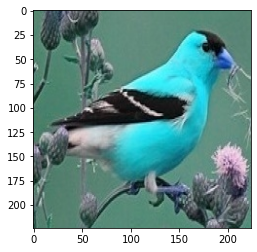

In [82]:
import random
import matplotlib.pyplot as plt
dummy = random.choice(img_pths)
plt.imshow(cv2.imread(dummy))
plt.show()

In [83]:
img_pths = img_pths[:3000]

In [84]:


BD = BirdDataset(img_pths, device = DEVICE)
l = len(BD)
train_dataloader = DataLoader(BD,
                              batch_size = 32,
                              shuffle = True)
encoder = Encoder().to(DEVICE)
discrete = discretize(512,128).to(DEVICE)
decoder = Decoder().to(DEVICE)
optimizer = Adam(list(encoder.parameters())+list(decoder.parameters()), lr = 2e-4)
codebook_optimizer = Adam(discrete.parameters(), lr = 2e-2)
trainer = Trainer(encoder, discrete, decoder, optimizer, codebook_optimizer, load_pretrained=True)

loading weights...
weights loaded..


In [85]:
enc = encoder(torch.zeros((1,3,128,128)).to(DEVICE))
latent, loss, perplexity = discrete(enc)

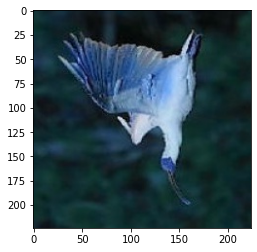

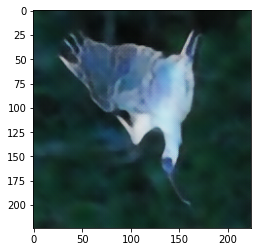

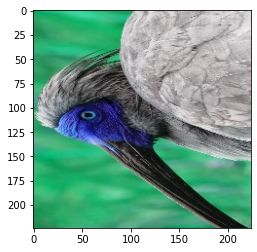

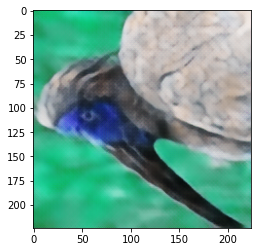

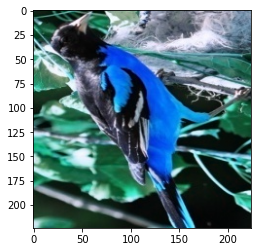

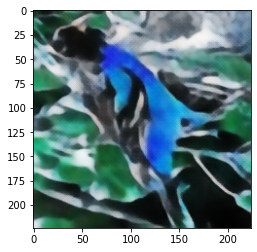

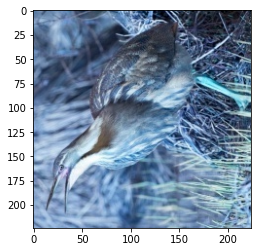

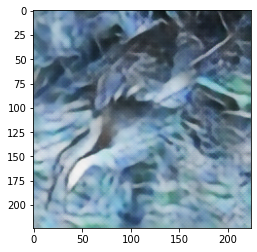

KeyboardInterrupt: ignored

In [89]:
for epoch in range(200):
    trainer.test(train_dataloader)
    trainer.fit(train_dataloader, l, epoch, save = False)